In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

c:\Users\kosty\anaconda3\envs\conda_3_9_11\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


character                                             dialog   seasons
0    Stewie   Damn you, vile woman! Youve impeded my work s...  season 1
1    Stewie                                     Hello, Mother.  season 1
2      Lois                          Well, hi, there, sweetie!  season 1
3    Stewie   You know, Mother, life is like a box of choco...  season 1
4    Stewie   Now, I offer you one last chance for deliverance  season 1

character  dialog    seasons
count       1377    1377       1377
unique         9    1285         11
top        Peter   What?  season 12
freq         394       9        217

character            
Peter                    394
Stewie                   269
Brian                    211
Lois                     184
Chris                    113
Meg                       85
Quagmire                  78
Cleveland                 40
Maids and Butlers M&B      3
Name: count, dtype: int64

Fraction of responses within the response distance    0.893401
dtype: float64


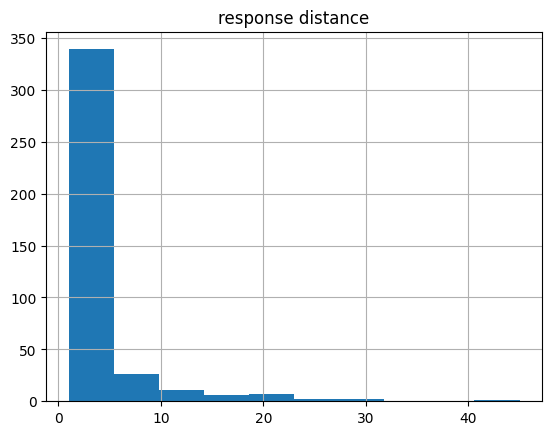

In [2]:
data = pd.read_csv('Family_guy_dialog.csv')
display(data.head())
display(data.describe())
display(data[['character']].value_counts())

CHARACTER_NAME = 'Peter'
response_window = 7

character_response_distance = []
index_left = 0
for index, row in data.iterrows():
    if row['character'] == CHARACTER_NAME:
        character_response_distance.append(index - index_left)
        index_left = index

character_response_distance_df = pd.DataFrame(character_response_distance,columns=['response distance'])
character_response_distance_df.hist()
fraction_of_responses_within_window = character_response_distance_df[character_response_distance_df['response distance'] <= response_window].count() / character_response_distance_df.count()
print(f'Fraction of responses within the {fraction_of_responses_within_window}')


In [3]:

contexted = []

for i in data[data['character'] == CHARACTER_NAME].index:
    if i < response_window:
        continue #remove if a context is less than 7 phrases

    prev = i - 1 - response_window
    row = []
    for j in range(i,prev,-1):
        row.append(data['dialog'][j])
    contexted.append(row)

columns = ['response', 'context']
columns = columns + ['context/' + str(i) for i in range(response_window-1)]

df = pd.DataFrame(contexted,columns=columns)
pd.set_option('display.max_colwidth', None)
display(df.head())
df.describe()

response   
0   after losing his Cheesy Charlies reservation Chris, this is a big day for you. Today you become the man of the house, because when we get home, your mother is going to kill me.  \
1                                                                                                          I cant even watch TV anymore. All the shows are starting to run together.   
2                                                                                                                                          Look, Chris. Its a whole family of wasps.   
3                                                                                                                    Canada sucks! Peter has a flashback of when he was on Jeopardy!   
4                                                    rings in Diarrhea. the crowd laughs What? Oh. Oh. Oh. Sorry. Sorry. What is diarrhea? after seeing the news about the heat wave   

                                                                                                                 context   
0   in his diary Day 171. Ive sprouted another finger. Counting the one from yesterday, looks at his penis, Im up to 11.  \
1                                   No, its not all right! For the love of God, shake me, shake me like a British Nanny!   
2                                                                                                         Uh, you first.   
3                                                                              Look, Chris. Its a whole family of wasps.   
4                                                        Canada sucks! Peter has a flashback of when he was on Jeopardy!   

                                                                          context/0   
0                                                  Well then, my goal becomes clear  \
1   Oh honey, I know youre hurting, but Mommy has to clean up the house, all right?   
2                                                            So, do you like music?   
3                                                                    Uh, you first.   
4                                         Look, Chris. Its a whole family of wasps.   

                                                                                                                        context/1   
0                                                                     Honey, its not gonna go away just because you dont like it.  \
1                                                                                 Very well then. I order you to kill me at once!   
2   Gosh, Id like to help you, Peter, but uh, Ive gotta go out in the hall and chew on the back of my ass for about five minutes.   
3                                                                                                          So, do you like music?   
4                                                                                                                  Uh, you first.   

                                                                                                                        context/2   
0               Very well then. ILois shoves the broccoli into his mouth. Stewie spits it out. Who the hell do you think you are?  \
1                                                             Oh, youre just teething, Stewie, its a normal part of a babys life.   
2                                                       I cant even watch TV anymore. All the shows are starting to run together.   
3   Gosh, Id like to help you, Peter, but uh, Ive gotta go out in the hall and chew on the back of my ass for about five minutes.   
4                                                                                                          So, do you like music?   

                                                                                                                                           context/3   
0                                                

response context          context/0 context/1 context/2 context/3   
count       394     394                394       394       394       394  \
unique      386     382                387       386       382       383   
top       What?   What?   Go to your room.     What?   Indeed.     What?   
freq          3       4                  3         4         3         5   

       context/4 context/5  
count        394       394  
unique       384       385  
top        What?     What?  
freq           5         3

Используем следующий подход:
1) Векторизуем контекст используя предобученный трансформер
2) Используя тот-же трансформер векторизуем input
3) Используя косинусную близость будем сопостовлять input - context
4) Возвращаем соответствующий response 

In [4]:


model_name = 'distilbert-base-uncased'
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def mean_pooling(model_output, attention_mask):
    """Perform mean pooling on model output with attention mask."""
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [12]:
%%time

context_columns = ['context'] + ['context/' + str(i) for i in range(response_window-1)]
context_embeddings = []

for index, row in df.iterrows():
    if index < 1000:

        sentence = ' '.join([context for context in row[context_columns]])
        # print(sentence)
        input_sentence = tokenizer(sentence, padding=True, truncation=True, max_length=512,return_tensors='pt')

        with torch.no_grad():
            outputs = model(**input_sentence)
        # print(outputs.last_hidden_state.shape)

        # Perform mean pooling on output
        pooled_output = mean_pooling(outputs, input_sentence['attention_mask'])
        # print(pooled_output.shape)
        context_embeddings.append(pooled_output)

vectorized_context = torch.stack(context_embeddings)
vectorized_context = vectorized_context.squeeze(1)
print(vectorized_context.shape)

torch.Size([394, 768])
CPU times: total: 2min 38s
Wall time: 19.9 s


In [13]:
user_input = "Do you want to go out?"

# Get embedding for user input
new_inputs = tokenizer(user_input, padding=True, truncation=True, max_length=512,return_tensors='pt')

with torch.no_grad():
    outputs = model(**new_inputs)
# print(outputs.last_hidden_state.shape)
new_pooled_input = mean_pooling(outputs, new_inputs['attention_mask'])
# print(new_pooled_input.shape)

cosine_similarities = F.cosine_similarity(new_pooled_input, vectorized_context)


# Find the best match
best_match_index = cosine_similarities.argmax()
selected_response = df.response[best_match_index.item()]  # Replace with the list of your actual responses
selected_response

" Hey, isn't that funny? He heard me say that on the way over in the car."

In [15]:
# Let's implement continouos chatting
dialog_context = ''
for step in range(6):
    new_user_input = input('You:')
    dialog_context = ' '.join([dialog_context,new_user_input],)

    # Get embedding for user input
    new_inputs = tokenizer(dialog_context, padding=True, truncation=True, max_length=512,return_tensors='pt')

    with torch.no_grad():
        outputs = model(**new_inputs)
    # print(outputs.last_hidden_state.shape)
    new_pooled_input = mean_pooling(outputs, new_inputs['attention_mask'])
    # print(new_pooled_input.shape)

    cosine_similarities = F.cosine_similarity(new_pooled_input, vectorized_context)


    # Find the best match
    best_match_index = cosine_similarities.argmax()
    selected_response = df.response[best_match_index.item()]  # Replace with the list of your actual responses

    print(f"You: {new_user_input}")
    print(f"Peter: {selected_response}")

    dialog_context = '. '.join([dialog_context,selected_response],)

You: How are you doing?
Peter:  Oh, guilty is the other one? exasperated Well, I don't know.
You: My name is Alice and I like you
Peter:  Until I'm not angry anymore, you naked buncha bitches!
You: Why are you angry with me?
Peter:  Enough!... was a movie with Jennifer Lopez that did not live to expectations.
You: My favorite movie
Peter:  What the hell kind of dog is that?
You: 213
Peter:  What the hell kind of dog is that?
You: asd
Peter:  All right, I am totally flaccid, but thank you anyway, ma'am. I appreciate your time. hangs up
